# [Optional 10 points] Part 3. Topic model

In this part you will learn how to do topic modeling with common tools and assess the resulting quality of the models. 

In [25]:
import re
import string
import nltk
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import operator as op

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec

import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jerzy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jerzy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Jerzy\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jerzy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
data3 = pd.read_csv('data/data.csv')
data3.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


The provided data contain chunked stories by Edgar Allan Poe (EAP), Mary Shelley (MWS), and HP Lovecraft (HPL).

The dataset can be downloaded here: `https://drive.google.com/file/d/14tAjAzHr6UmFVFV7ABTyNHBh-dWHAaLH/view?usp=sharing`

#### Preprocess dataset with the functions from the Part 1

In [27]:
# removing HTML from raw data
pattern = re.compile('<.*?>') 
table = str.maketrans("","")
punct = string.punctuation + '“”0123456789‘’'

# function to repllace all the HTML with nothing
def remove_html(html):
  cleantext = re.sub(pattern, '', html)
  return cleantext.translate(str.maketrans('','', punct))

# apply the HTML-removing function
data3.text = data3.text.apply(remove_html)

# replace all the '\n's with nothing
data3.text = data3.text.apply(lambda x: x.replace('\n', ''))

# additionally remove javascript tags/words
def remove_tags(html):
    soup = BeautifulSoup(html, "html.parser")
    for data in soup(['style', 'script']):
        data.decompose()
    return ' '.join(soup.stripped_strings)

data3.text = data3.text.apply(remove_tags)

# remove non english words and stop words
words = set(nltk.corpus.words.words()).difference(set(stopwords.words('english')))
def non_english(i):
    return [w for w in nltk.wordpunct_tokenize(i) if w.lower() in words ]
data3['text_splitted'] = data3.text.apply(non_english)

# lemmatize function
lemmatizer = WordNetLemmatizer()
def lemmatize(i):
    return [lemmatizer.lemmatize(w) for w in i]

# remove single characters
def join(i):
    return " ".join(w for w in i if len(w) > 1)


# lemmatize

data3.text_splitted = data3.text_splitted.apply(lemmatize)
data3['text_preprocessed'] = data3.text_splitted.apply(join)

data_preprocessed = data3[['text_preprocessed', 'text_splitted']]

# make list, lower
list_of_words = data_preprocessed.text_splitted.to_list()
list_of_words

[['process',
  'however',
  'dungeon',
  'might',
  'make',
  'circuit',
  'return',
  'point',
  'whence',
  'set',
  'without',
  'aware',
  'fact',
  'perfectly',
  'uniform',
  'wall'],
 ['never', 'fumbling', 'might', 'mere', 'mistake'],
 ['left',
  'hand',
  'gold',
  'snuff',
  'box',
  'hill',
  'cutting',
  'manner',
  'fantastic',
  'took',
  'snuff',
  'incessantly',
  'air',
  'possible',
  'self',
  'satisfaction'],
 ['lovely',
  'spring',
  'Terrace',
  'sixteen',
  'fertile',
  'spread',
  'beneath',
  'speckled',
  'happy',
  'former',
  'heart',
  'cheering',
  'fair'],
 ['Finding',
  'nothing',
  'else',
  'even',
  'gold',
  'Superintendent',
  'abandoned',
  'perplexed',
  'look',
  'occasionally',
  'countenance',
  'thinking',
  'desk'],
 ['youth',
  'solitude',
  'best',
  'spent',
  'gentle',
  'feminine',
  'fosterage',
  'refined',
  'groundwork',
  'character',
  'cannot',
  'overcome',
  'intense',
  'distaste',
  'usual',
  'brutality',
  'board',
  'ship',


#### Quality estimation

Implement the following three quality fuctions: `coherence` (or `tf-idf coherence`), `normalized PMI`, `based on the distributed word representation`(you can use pretrained w2v vectors or some other model). You are free to use any libraries (for instance gensim) and components.

In [28]:
def coherence(topics, texts):
    word2id = corpora.Dictionary(texts)
    cm = CoherenceModel(topics=topics, texts=texts,
                        coherence='c_v', dictionary=word2id)
    return cm.get_coherence_per_topic()


def normalized_PMI(topics, texts):
    word2id = corpora.Dictionary(texts)
    cm = CoherenceModel(topics=topics, texts=texts,
                        coherence='c_npmi', dictionary=word2id)
    return list(map(abs, cm.get_coherence_per_topic()))

model = Word2Vec(list_of_words, min_count=3)

def dist_words(list_of_words, model):
    def distance(word_1: list, word_2):
        v1 = model[word_1]
        v2 = model[word_2]
        s = 0
        for i in range(len(v1)):
            sum_res += (v1[i] - v2[i])**2
        return s

    los_coh = []
    for sent in list_of_words:
        pairs = list(itertools.permutations(sent, 2))
        res = 0
        k = 0
        for word_1, word_2 in pairs:
            if word_1 != word_2:
                k += 1
                res += distance(word_1, word_2)

        res = res / (k*(k-1))
        los_coh.append(res)

    return(los_coh)



### Topic modeling

Read and preprocess the dataset, divide it into train and test parts `sklearn.model_selection.train_test_split`. Test part will be used in classification part. For simplicity we do not perform cross-validation here, but you should remember about it.

In [31]:
data3.head()

,id,text,author,text_splitted,text_preprocessed
0,id26305,This process however afforded me no means of a...,EAP,"[process, however, dungeon, might, make, circu...",process however dungeon might make circuit ret...
1,id17569,It never once occurred to me that the fumbling...,HPL,"[never, fumbling, might, mere, mistake]",never fumbling might mere mistake
2,id11008,In his left hand was a gold snuff box from whi...,EAP,"[left, hand, gold, snuff, box, hill, cutting, ...",left hand gold snuff box hill cutting manner f...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,"[lovely, spring, Terrace, sixteen, fertile, sp...",lovely spring Terrace sixteen fertile spread b...
4,id12958,Finding nothing else not even gold the Superin...,HPL,"[Finding, nothing, else, even, gold, Superinte...",Finding nothing else even gold Superintendent ...


Plot the histogram of resulting tokens counts in the processed datasets.

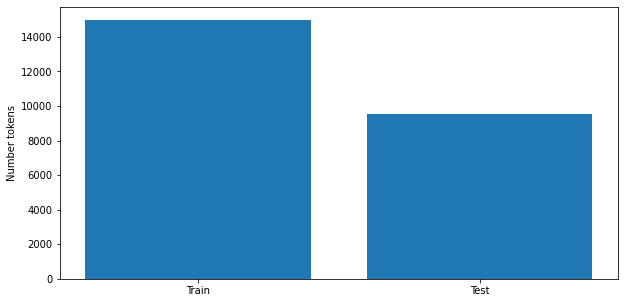

In [46]:
train, test = train_test_split(data3, test_size=0.25, random_state=42)
train_token_dict = {}
test_token_dict = {}

for index, row in train.iterrows():
    for item in row["text_splitted"]:
        if item in train_token_dict:
            train_token_dict[item] += 1
        else:
            train_token_dict[item] = 0
            
for index, row in test.iterrows():
    for item in row["text_splitted"]:
        if item in test_token_dict:
            test_token_dict[item] += 1
        else:
            test_token_dict[item] = 0

fig = plt.figure(figsize=(10,5))
plt.bar(["Train", "Test"], [len(train_token_dict), len(test_token_dict)])
plt.ylabel("Number tokens")
plt.show()

Plot the histogram of resulting tokens counts in the processed datasets.

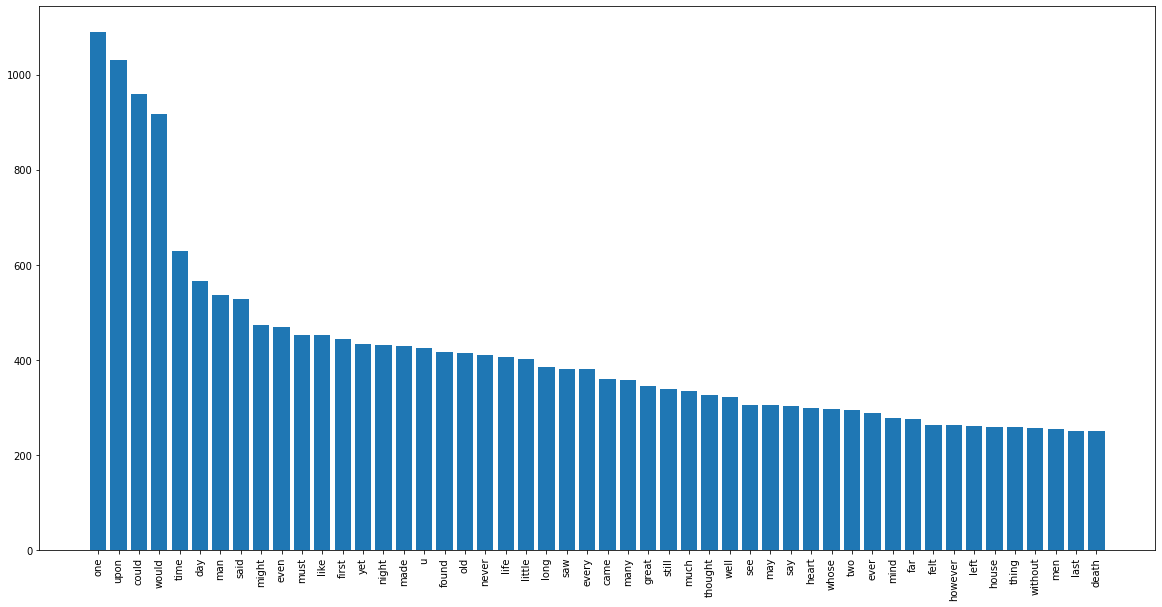

In [38]:
res = dict(sorted(train_token_dict.items(), key = op.itemgetter(1), reverse = True)[:50])
fig = plt.figure(figsize=(20,10))
plt.bar(res.keys(), res.values())
plt.xticks(rotation='vertical')
plt.show()

#### NMF

Implement topic modeling with NMF (you can use `sklearn.decomposition.NMF`) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

C:\Users\Jerzy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\Jerzy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\Jerzy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


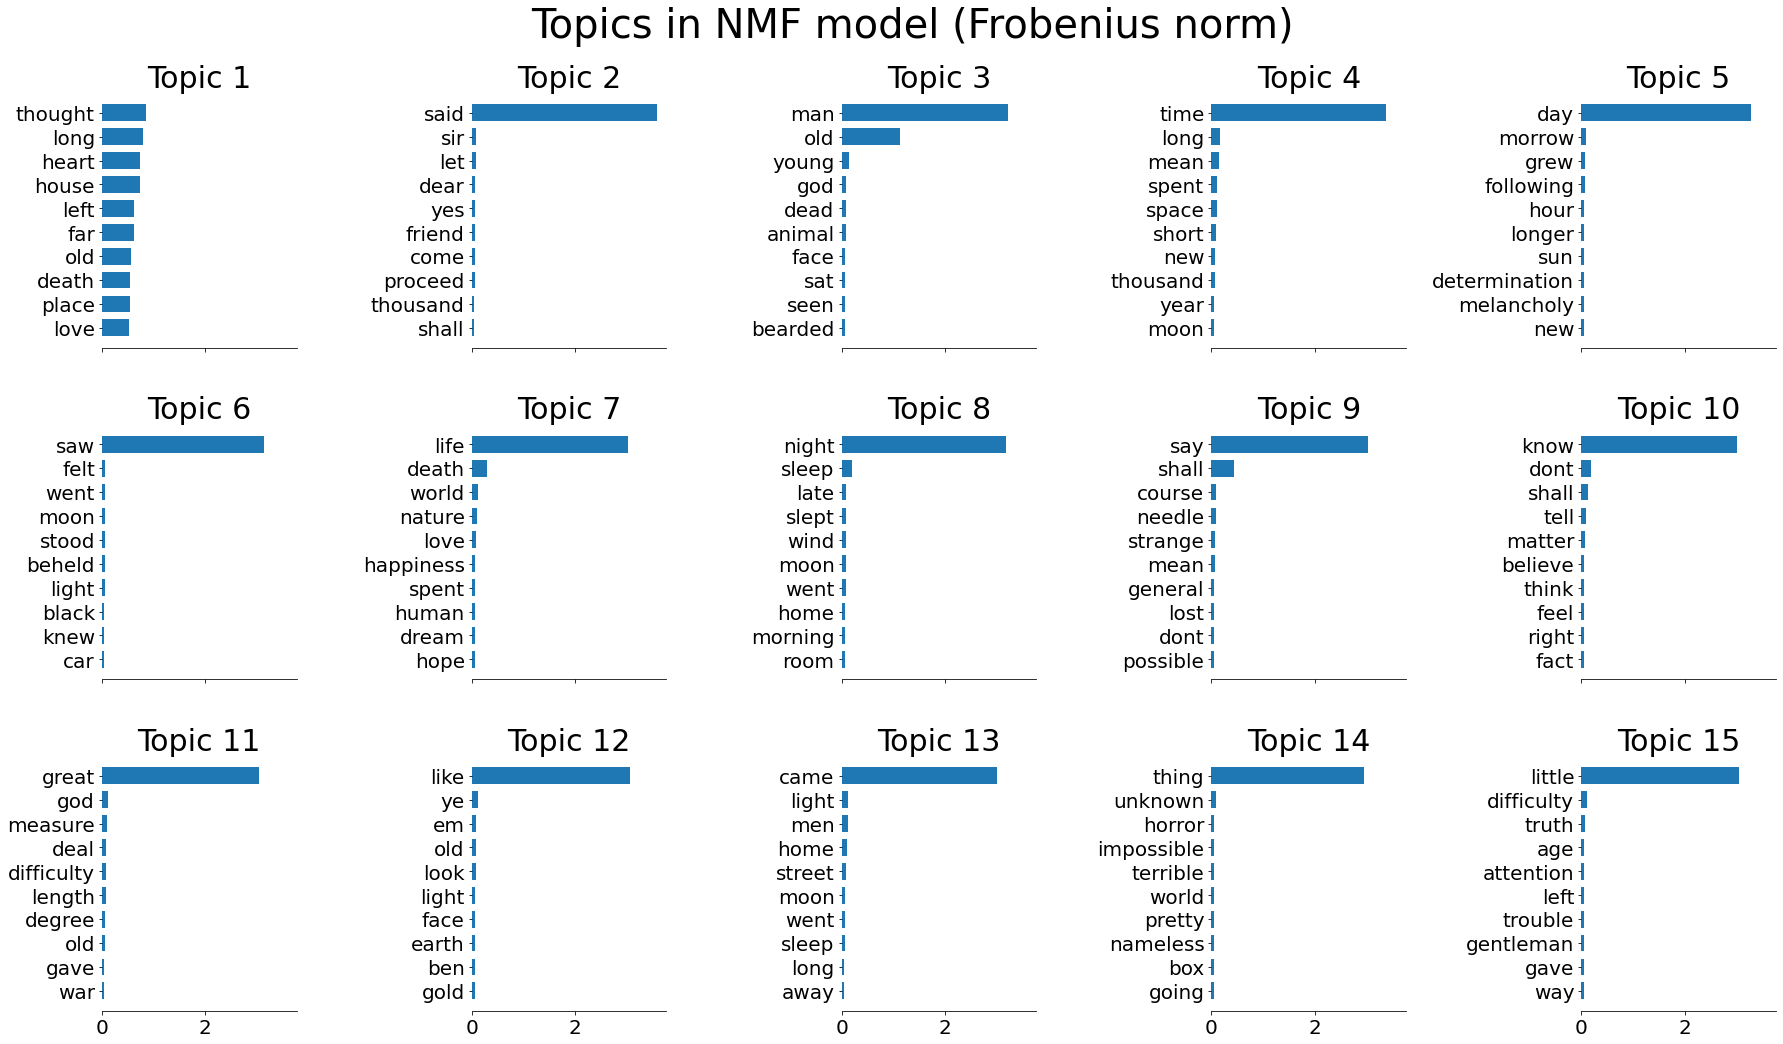

In [57]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=2000, stop_words="english")
los = data3['text_preprocessed'].to_list()
tfidf = tfidf_vectorizer.fit_transform(los)

nmf = NMF(n_components=15, random_state=42, alpha=0.3, l1_ratio=0.1).fit(tfidf)

# borrowed from https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1: -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.9, hspace=0.3)
    plt.show()


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, 10,
               "Topics in NMF model (Frobenius norm)")


#### LDA

Implement topic modeling with LDA (you can use gensim implementation) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

C:\Users\Jerzy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


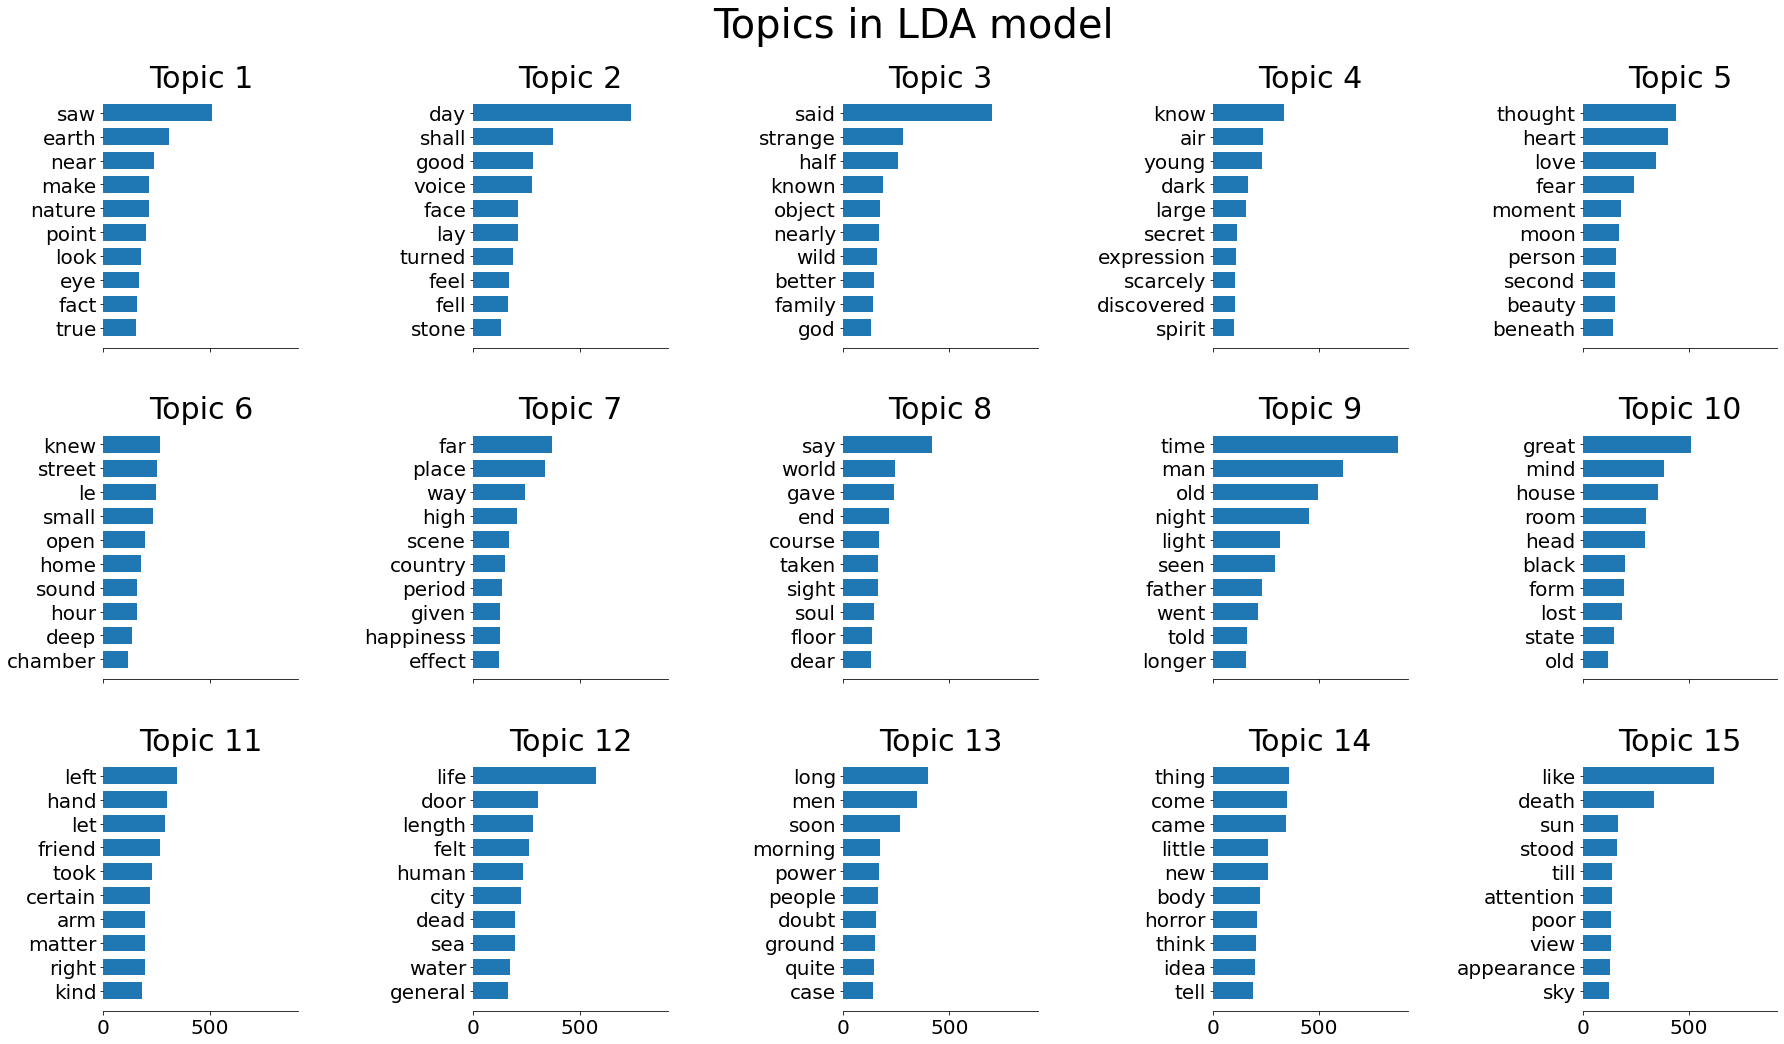

In [49]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words="english")
tf = tf_vectorizer.fit_transform(los)
lda = LatentDirichletAllocation(
    n_components=15, max_iter=7, learning_method="online", learning_offset=50.0, random_state=42)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, 10, "Topics in LDA model")


### Additive regularization of topic models 

Implement topic modeling with ARTM. You may use bigartm library (simple installation for linux: pip install bigartm) or TopicNet framework (`https://github.com/machine-intelligence-laboratory/TopicNet`)

Create artm topic model fit it to the data. Try to change hyperparameters (number of specific and background topics) to better fit the dataset. Play with smoothing and sparsing coefficients (use grid), try to add decorrelator. Print out resulting topics.

Write a function to convert new documents to topics probabilities vectors.

Calculate the quality scores for each model. Make a barplot to compare the quality.